# RAG & GraphRAG over a Relational Schema

This notebook demonstrates:

1. A simple **relational RAG** pattern:
   - Filter with "SQL" (simulated using pandas DataFrames)
   - Create textual summaries per row
   - Embed and retrieve relevant rows for a user question

2. A **GraphRAG-style approach**:
   - Build a small knowledge graph on top of the same schema
   - Use graph traversal to find a relevant neighborhood
   - Run RAG *on that neighborhood* for more relational / multi-hop questions

In a real enterprise setting, you would:
- Replace the pandas DataFrames with your actual warehouse / OLTP DB
- Replace the fake embeddings with a real embedding model (OpenAI, Snowflake Cortex, etc.)
- Replace the in-memory NetworkX graph with a GraphDB (Neo4j, Neptune, etc.)

## 1. Mock Relational Schema

We'll simulate a simple schema with three tables:

- `customers`: basic customer profile
- `orders`: orders placed by customers
- `tickets`: support tickets raised by customers

Assume that, in production, each of these tables has **millions of rows**.

In [1]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any
from dataclasses import dataclass

# For the GraphRAG part
import networkx as nx

# Set a fixed random seed for reproducibility (only affects fake embeddings)
RNG = np.random.default_rng(42)

### Create Mock Tables

We'll create a few example rows. In a real system, this schema would be populated
with millions of records.

In [2]:
customers = pd.DataFrame(
    [
        {"customer_id": 1, "name": "Acme Corp", "segment": "Enterprise", "region": "NA"},
        {"customer_id": 2, "name": "Globex Inc", "segment": "Mid-Market", "region": "EU"},
        {"customer_id": 3, "name": "Initech", "segment": "SMB", "region": "NA"},
    ]
)

orders = pd.DataFrame(
    [
        {"order_id": 101, "customer_id": 1, "product": "Observability Suite", "amount": 250000, "status": "Active"},
        {"order_id": 102, "customer_id": 1, "product": "Incident Automation", "amount": 90000, "status": "Churned"},
        {"order_id": 103, "customer_id": 2, "product": "Observability Suite", "amount": 60000, "status": "Active"},
        {"order_id": 104, "customer_id": 3, "product": "Log Analytics", "amount": 15000, "status": "Trial"},
    ]
)

tickets = pd.DataFrame(
    [
        {"ticket_id": 1001, "customer_id": 1, "severity": "P1", "topic": "Frequent outages", "status": "Open"},
        {"ticket_id": 1002, "customer_id": 1, "severity": "P2", "topic": "Slow dashboards", "status": "Closed"},
        {"ticket_id": 1003, "customer_id": 2, "severity": "P3", "topic": "Billing questions", "status": "Open"},
        {"ticket_id": 1004, "customer_id": 3, "severity": "P1", "topic": "Agent CPU usage", "status": "Closed"},
    ]
)

customers, orders, tickets.head(), tickets.head()

(   customer_id        name     segment region
 0            1   Acme Corp  Enterprise     NA
 1            2  Globex Inc  Mid-Market     EU
 2            3     Initech         SMB     NA,
    order_id  customer_id              product  amount   status
 0       101            1  Observability Suite  250000   Active
 1       102            1  Incident Automation   90000  Churned
 2       103            2  Observability Suite   60000   Active
 3       104            3        Log Analytics   15000    Trial,
    ticket_id  customer_id severity              topic  status
 0       1001            1       P1   Frequent outages    Open
 1       1002            1       P2    Slow dashboards  Closed
 2       1003            2       P3  Billing questions    Open
 3       1004            3       P1    Agent CPU usage  Closed,
    ticket_id  customer_id severity              topic  status
 0       1001            1       P1   Frequent outages    Open
 1       1002            1       P2    Slow dash

In production, these tables would live in a database like Postgres, Snowflake, BigQuery, etc.
The schema would be the same; only the **row counts** would be much larger.


## 2. Classic Relational RAG Pattern

flowchart LR
  U[User Query] --> O[LLM Orchestrator / Agent]

  O --> R1[SQL / Metadata Retriever]
  R1 -->|Filters (time, account, product, status)| DB[Relational DB]
  DB --> ROWS[Candidate Rows<br/> hundreds–thousands]

  ROWS --> V[Embed / Vector Store Lookup]
  V --> TOPK[Top-k Row Snippets]

  TOPK --> A[Answer LLM<br/>RAG Synthesis]
  A --> U

### 2.1. Textual "Row Summaries" for RAG

We want to answer questions like:

> "Why is Acme Corp at risk of churn?"

We'll:
- Join data from multiple tables
- Create concise textual summaries
- Embed those summaries
- Retrieve top-k summaries given a user question

In [4]:
def build_customer_context_rows(
    customers: pd.DataFrame, orders: pd.DataFrame, tickets: pd.DataFrame
) -> pd.DataFrame:
    """
    Build an aggregated, textual view per customer to use as the RAG 'document'.
    """
    # Aggregate orders
    order_agg = (
        orders.groupby("customer_id")
        .agg(
            total_revenue=("amount", "sum"),
            products=("product", lambda x: list(sorted(set(x)))),
            churned_products=("status", lambda x: list(sorted(set([s for s in x if s == "Churned"])))),
        )
        .reset_index()
    )

    # Aggregate tickets
    ticket_agg = (
        tickets.groupby("customer_id")
        .agg(
            open_p1=("severity", lambda x: sum((s == "P1") for s in x)),
            open_tickets=("status", lambda x: sum((s == "Open") for s in x)),
            topics=("topic", lambda x: list(x)),
        )
        .reset_index()
    )

    df = customers.merge(order_agg, on="customer_id", how="left").merge(ticket_agg, on="customer_id", how="left")

    # First: fill scalar numeric values safely
    df = df.fillna({
        "total_revenue": 0,
        "open_p1": 0,
        "open_tickets": 0,
    })

    # Second: fill list columns using apply (because fillna doesn't accept lists)
    for list_col in ["products", "churned_products", "topics"]:
        df[list_col] = df[list_col].apply(lambda x: x if isinstance(x, list) else [])
        
    def make_summary(row):
        return (
            f"Customer {row['name']} (segment: {row['segment']}, region: {row['region']}). "
            f"Total revenue: {row['total_revenue']}. "
            f"Products: {', '.join(row['products']) or 'None'}. "
            f"Churned products: {', '.join(row['churned_products']) or 'None'}. "
            f"Open P1 tickets: {row['open_p1']}. "
            f"Open tickets: {row['open_tickets']}. "
            f"Recent ticket topics: {', '.join(row['topics']) or 'None'}."
        )

    df["summary"] = df.apply(make_summary, axis=1)
    return df[["customer_id", "name", "summary"]]


customer_context = build_customer_context_rows(customers, orders, tickets)
customer_context

,customer_id,name,summary
0,1,Acme Corp,"Customer Acme Corp (segment: Enterprise, regio..."
1,2,Globex Inc,"Customer Globex Inc (segment: Mid-Market, regi..."
2,3,Initech,"Customer Initech (segment: SMB, region: NA). T..."


## 2. Classic Relational RAG Pattern

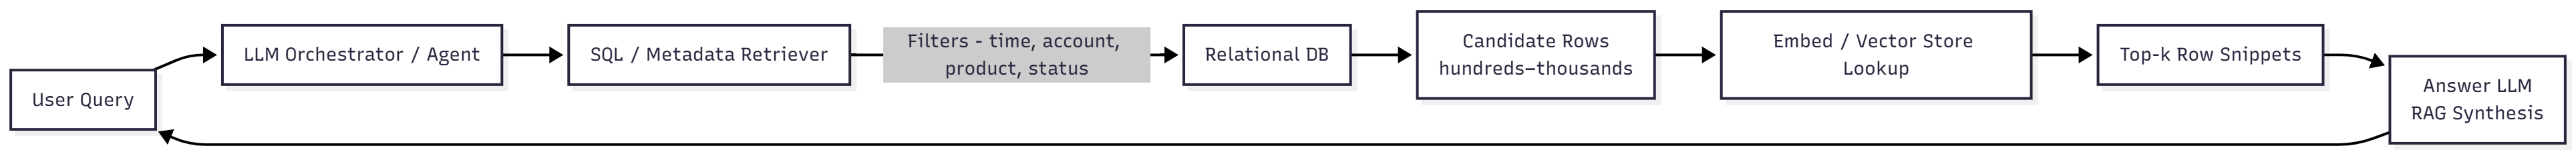

### 2.1. Textual "Row Summaries" for RAG

We want to answer questions like:

> "Why is Acme Corp at risk of churn?"

We'll:
- Join data from multiple tables
- Create concise textual summaries
- Embed those summaries
- Retrieve top-k summaries given a user question

### 2.2. Fake Embeddings (Replace with Real Model in Production)

We use deterministic pseudo-random vectors as stand-ins for real embeddings so the notebook runs offline.

In a real system, you would do something like:

```python
from openai import OpenAI
client = OpenAI()

def embed_text(text: str) -> np.ndarray:
    resp = client.embeddings.create(
        model="text-embedding-3-large",
        input=[text]
    )
    return np.array(resp.data[0].embedding)
```

In [5]:
EMBED_DIM = 64 # small dim for the example

def fake_embed_text(text: str) -> np.ndarray:
    """
    Deterministic 'fake' embedding based on text hash.
    """
    seed = abs(hash(text)) % (2**32)
    rng = np.random.default_rng(seed)
    return rng.normal(size=(EMBED_DIM,))

def embed_corpus(df: pd.DataFrame, text_col: str = "summary") -> np.ndarray:
    vectors = np.vstack([fake_embed_text(t) for t in df[text_col].tolist()])
    return vectors

customer_vectors = embed_corpus(customer_context, "summary")
customer_vectors.shape


(3, 64)

### 2.3. Simple Vector Retrieval
We'll:
- Embed the user query
- Compute cosine similarity vs. all customer summaries
- Return the top-k customers as context

In [6]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))

def retrieve_customers(question: str, top_k: int = 2):
    q_vec = fake_embed_text(question)
    sims = [cosine_sim(q_vec, v) for v in customer_vectors]
    indices = np.argsort(sims)[::-1][:top_k]
    return customer_context.iloc[indices].assign(score=[sims[i] for i in indices])

example_question = "Why is Acme Corp at risk of churn, and what issues are they facing?"
retrieve_customers(example_question, top_k=3)

,customer_id,name,summary,score
0,1,Acme Corp,"Customer Acme Corp (segment: Enterprise, regio...",0.239732
1,2,Globex Inc,"Customer Globex Inc (segment: Mid-Market, regi...",0.075303
2,3,Initech,"Customer Initech (segment: SMB, region: NA). T...",-0.128087


### 2.4. Agentic Answer Stub
In a real system, an agent (LLM) would:
- Decide which tool to use (relational_rag, graph_rag, docs_rag, etc.)
- Call the retriever
- Use the results as context in a final generation step

Below is a simplified version that just concatenates retrieved context.

In [8]:
def answer_with_relational_rag(question: str, top_k: int = 2) -> str:
    retrieved = retrieve_customers(question, top_k=top_k)
    context_blocks = []
    for _, row in retrieved.iterrows():
        context_blocks.append(f"[Customer {row['name']}]\n{row['summary']}\n")
        context = "\n".join(context_blocks)

    # In production: call LLM with this context
    # Here we just echo a template.
    
    answer = (
        f"QUESTION: {question}\n\n"
        f"CONTEXT (top {top_k} customers):\n{context}\n"
        "LLM_ANSWER (pseudo): Based on the context above, here is how I would explain the situation..."
    )
    return answer

print(answer_with_relational_rag(example_question, top_k=2))


QUESTION: Why is Acme Corp at risk of churn, and what issues are they facing?

CONTEXT (top 2 customers):
[Customer Acme Corp]
Customer Acme Corp (segment: Enterprise, region: NA). Total revenue: 340000. Products: Incident Automation, Observability Suite. Churned products: Churned. Open P1 tickets: 1. Open tickets: 1. Recent ticket topics: Frequent outages, Slow dashboards.

[Customer Globex Inc]
Customer Globex Inc (segment: Mid-Market, region: EU). Total revenue: 60000. Products: Observability Suite. Churned products: None. Open P1 tickets: 0. Open tickets: 1. Recent ticket topics: Billing questions.

LLM_ANSWER (pseudo): Based on the context above, here is how I would explain the situation...


This demonstrates a classic relational RAG pattern:
- Coarse-grain selection via query (or time filters, segment, region, etc.)
- Vector similarity over textual summaries
- Context passed to an LLM for answer synthesis

In a real deployment:
- Step 1 might be actual SQL, not DataFrame filtering
- Step 2 might use a proper vector DB (pgvector, Pinecone, etc.)
= Step 3 uses an LLM API

## 3. Building a Simple Knowledge Graph

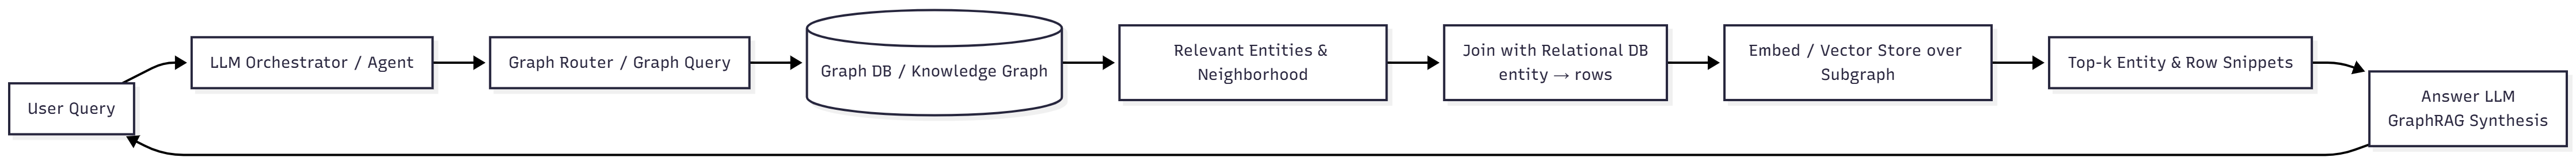

Now let's layer a graph on top of the same data. We'll create a graph with:
= Node types: Customer, Order, Ticket
= Edges:
    - Customer → Order (PLACED)
    - Customer → Ticket (RAISED)
    - Optionally, Order → Ticket or service dependencies, etc.

This simulates what you'd store in a GraphDB (Neo4j, Neptune, etc.).

In [10]:
G = nx.MultiDiGraph()

# Add customer nodes
for _, row in customers.iterrows():
    G.add_node(
    f"customer:{row['customer_id']}",
    label="Customer",
    customer_id=row["customer_id"],
    name=row["name"],
    segment=row["segment"],
    region=row["region"],
    )

# Add order nodes and edges
for _, row in orders.iterrows():
    node_id = f"order:{row['order_id']}"
    G.add_node(
        node_id,
        label="Order",
        order_id=row["order_id"],
        customer_id=row["customer_id"],
        product=row["product"],
        amount=row["amount"],
        status=row["status"],
    )
    G.add_edge(f"customer:{row['customer_id']}", node_id, relation="PLACED")

# Add ticket nodes and edges
for _, row in tickets.iterrows():
    node_id = f"ticket:{row['ticket_id']}"
    G.add_node(
        node_id,
        label="Ticket",
        ticket_id=row["ticket_id"],
        customer_id=row["customer_id"],
        severity=row["severity"],
        topic=row["topic"],
        status=row["status"],
    )
    G.add_edge(f"customer:{row['customer_id']}", node_id, relation="RAISED")

len(G.nodes()), len(G.edges())

(11, 8)

### 3.1. Graph-Based Node Descriptions
We now define textual descriptions for nodes. In a real GraphRAG system, these might be:
- Long-form descriptions of entities
- Enriched with logs, comments, documentation, etc.

In [11]:
def describe_node(node_id: str, attrs: Dict[str, Any]) -> str:
    label = attrs.get("label")
    if label == "Customer":
        return (
            f"Customer {attrs['name']} (segment: {attrs['segment']}, region: {attrs['region']}). "
            f"Node: {node_id}."
        )
    elif label == "Order":
        return (
            f"Order {attrs['order_id']} for customer {attrs['customer_id']}. "
            f"Product: {attrs['product']}, amount: {attrs['amount']}, status: {attrs['status']}. "
            f"Node: {node_id}."
        )
    elif label == "Ticket":
        return (
            f"Ticket {attrs['ticket_id']} for customer {attrs['customer_id']}. "
            f"Severity: {attrs['severity']}, topic: {attrs['topic']}, status: {attrs['status']}. "
            f"Node: {node_id}."
        )
    else:
        return f"Node {node_id} with attributes {attrs}"

# Precompute descriptions & embeddings
node_descriptions = {}
node_vectors = {}

for node_id, attrs in G.nodes(data=True):
    desc = describe_node(node_id, attrs)
    node_descriptions[node_id] = desc
    node_vectors[node_id] = fake_embed_text(desc)

len(node_descriptions)

11

### 3.2. GraphRAG Retrieval
A rough GraphRAG pattern: 
- Embed user question
- Compute similarity to node descriptions (e.g. Customers, Tickets)
- Take the top-N nodes as entry points
- Traverse the graph to collect a small neighborhood (e.g. radius 1–2)
- Build context from the neighborhood (customers + tickets + orders)
- Feed that into the LLM

This lets you answer relational / multi-hop questions more naturally.

In [12]:
def retrieve_graph_neighborhood(question: str, top_n_nodes: int = 3, max_hops: int = 2):
    q_vec = fake_embed_text(question)

    # Rank nodes by similarity to the question
    scores = []
    for node_id, vec in node_vectors.items():
        scores.append((node_id, cosine_sim(q_vec, vec)))
    scores.sort(key=lambda x: x[1], reverse=True)

    seed_nodes = [node_id for node_id, _ in scores[:top_n_nodes]]

    # BFS up to max_hops for each seed node
    neighborhood = set()
    for seed in seed_nodes:
        neighborhood.add(seed)
        # simple BFS
        queue = [(seed, 0)]
        while queue:
            current, depth = queue.pop(0)
            if depth >= max_hops:
                continue
            # neighbors in both directions
            neighbors = list(G.predecessors(current)) + list(G.successors(current))
            for nb in neighbors:
                if nb not in neighborhood:
                    neighborhood.add(nb)
                    queue.append((nb, depth + 1))

    # Build context text
    context_nodes = sorted(list(neighborhood))
    context_texts = [f"[{nid}] {node_descriptions[nid]}" for nid in context_nodes]

    return {
        "seed_nodes": seed_nodes,
        "neighborhood_nodes": context_nodes,
        "context_text": "\n".join(context_texts),
    }
    
graph_question = "What critical issues is Acme Corp facing and how might it affect their subscriptions?"
graph_result = retrieve_graph_neighborhood(graph_question, top_n_nodes=3, max_hops=2)
graph_result["context_text"]

'[customer:1] Customer Acme Corp (segment: Enterprise, region: NA). Node: customer:1.\n[customer:3] Customer Initech (segment: SMB, region: NA). Node: customer:3.\n[order:101] Order 101 for customer 1. Product: Observability Suite, amount: 250000, status: Active. Node: order:101.\n[order:102] Order 102 for customer 1. Product: Incident Automation, amount: 90000, status: Churned. Node: order:102.\n[order:104] Order 104 for customer 3. Product: Log Analytics, amount: 15000, status: Trial. Node: order:104.\n[ticket:1001] Ticket 1001 for customer 1. Severity: P1, topic: Frequent outages, status: Open. Node: ticket:1001.\n[ticket:1002] Ticket 1002 for customer 1. Severity: P2, topic: Slow dashboards, status: Closed. Node: ticket:1002.\n[ticket:1004] Ticket 1004 for customer 3. Severity: P1, topic: Agent CPU usage, status: Closed. Node: ticket:1004.'

### 3.3. GraphRAG Answer Stub


In [13]:
def answer_with_graph_rag(question: str, top_n_nodes: int = 3, max_hops: int = 2) -> str:
    result = retrieve_graph_neighborhood(question, top_n_nodes=top_n_nodes, max_hops=max_hops)
    context = result["context_text"]

    # In production: call LLM with this context
    answer = (
        f"QUESTION: {question}\n\n"
        "GRAPH SEED NODES:\n"
        f"{result['seed_nodes']}\n\n"
        f"GRAPH CONTEXT (neighbors up to {max_hops} hops):\n{context}\n\n"
        "LLM_ANSWER (pseudo): Based on this graph neighborhood, here is how I would explain the situation..."
    )

    return answer

print(answer_with_graph_rag(graph_question, top_n_nodes=3, max_hops=2))

QUESTION: What critical issues is Acme Corp facing and how might it affect their subscriptions?

GRAPH SEED NODES:
['ticket:1004', 'order:102', 'customer:3']

GRAPH CONTEXT (neighbors up to 2 hops):
[customer:1] Customer Acme Corp (segment: Enterprise, region: NA). Node: customer:1.
[customer:3] Customer Initech (segment: SMB, region: NA). Node: customer:3.
[order:101] Order 101 for customer 1. Product: Observability Suite, amount: 250000, status: Active. Node: order:101.
[order:102] Order 102 for customer 1. Product: Incident Automation, amount: 90000, status: Churned. Node: order:102.
[order:104] Order 104 for customer 3. Product: Log Analytics, amount: 15000, status: Trial. Node: order:104.
[ticket:1001] Ticket 1001 for customer 1. Severity: P1, topic: Frequent outages, status: Open. Node: ticket:1001.
[ticket:1002] Ticket 1002 for customer 1. Severity: P2, topic: Slow dashboards, status: Closed. Node: ticket:1002.
[ticket:1004] Ticket 1004 for customer 3. Severity: P1, topic: Agent

## 4. Comparing Classic Relational RAG vs GraphRAG
- In a real system with millions of rows:
    - Classic RAG over relational summaries:
        - Works well for questions about individual entities or simple aggregates.
        - Retrieval scans a large vector index (ANN makes this efficient, but still global).

- GraphRAG:
    - Focuses on entities and their relationships.
    - Retrieval happens in a smaller subgraph relevant to the question.

- Especially useful for:
    - Root cause analysis across services
    - Churn explanations involving multiple signals
    - Impact analysis (“if this service fails, who is affected?”)

Below is a simple simulation to illustrate the difference in search space size.

In [14]:
def compare_retrieval_scale(
    total_customers: int = 10_000_000,
    avg_neighbors_per_seed: int = 50,
    nodes_in_neighborhood: int = 500,
):
    """
    Very rough conceptual comparison.
    """
    relational_search_space = total_customers # imagine a global index over customers

    # GraphRAG: we only look at a local neighborhood
    graph_search_space = nodes_in_neighborhood

    print("=== Retrieval Search Space Comparison (Conceptual) ===")
    print(f"Total customers in DB (global index): {relational_search_space:,}")
    print(f"Approx. nodes examined in a GraphRAG neighborhood: {graph_search_space:,}")
    print(
        f"GraphRAG search space is ~{relational_search_space / graph_search_space:,.0f}x smaller "
        "for reasoning over this subgraph."
    )
    
compare_retrieval_scale()

=== Retrieval Search Space Comparison (Conceptual) ===
Total customers in DB (global index): 10,000,000
Approx. nodes examined in a GraphRAG neighborhood: 500
GraphRAG search space is ~20,000x smaller for reasoning over this subgraph.


- In reality, you'd have:
    - Multiple entity types (customers, services, teams, tickets, incidents, releases, etc.)
    - Weighted / typed edges (e.g., ownership, causality, dependency strength)
    - More powerful graph queries (Cypher, Gremlin, GQL)
    - A dedicated GraphRAG engine that:
        - Uses the graph to pick relevant nodes
        - Enriches them with text
        - Feeds them into an LLM for reasoning

- But the core idea remains:
    - Relational RAG focuses on rows; GraphRAG focuses on entities and relationships.

## 5. Hybrid Agent: Routing Between Relational RAG and GraphRAG

- Finally, we can simulate a simple routing strategy:
    - If the question is about one customer and "churn" → use GraphRAG
    - If the question is about overall statistics → use Relational RAG

In production, an LLM classifier (or agent) would make this decision.

In [15]:
def route_question(question: str) -> str:
    q_lower = question.lower()
    if "why" in q_lower and ("churn" in q_lower or "root cause" in q_lower or "impact" in q_lower):
        return "graph_rag"
    else:
        return "relational_rag"

def agentic_answer(question: str) -> str:
    route = route_question(question)
    if route == "graph_rag":
        return answer_with_graph_rag(question, top_n_nodes=3, max_hops=2)
    else:
        return answer_with_relational_rag(question, top_k=3)

print(agentic_answer("Why is Acme Corp at risk of churn?"))
print("\n" + "=" * 80 + "\n")
print(agentic_answer("Give me a general summary of our key customers."))

QUESTION: Why is Acme Corp at risk of churn?

GRAPH SEED NODES:
['customer:2', 'order:103', 'customer:3']

GRAPH CONTEXT (neighbors up to 2 hops):
[customer:2] Customer Globex Inc (segment: Mid-Market, region: EU). Node: customer:2.
[customer:3] Customer Initech (segment: SMB, region: NA). Node: customer:3.
[order:103] Order 103 for customer 2. Product: Observability Suite, amount: 60000, status: Active. Node: order:103.
[order:104] Order 104 for customer 3. Product: Log Analytics, amount: 15000, status: Trial. Node: order:104.
[ticket:1003] Ticket 1003 for customer 2. Severity: P3, topic: Billing questions, status: Open. Node: ticket:1003.
[ticket:1004] Ticket 1004 for customer 3. Severity: P1, topic: Agent CPU usage, status: Closed. Node: ticket:1004.

LLM_ANSWER (pseudo): Based on this graph neighborhood, here is how I would explain the situation...


QUESTION: Give me a general summary of our key customers.

CONTEXT (top 3 customers):
[Customer Acme Corp]
Customer Acme Corp (segmen